# Packages, Utils

In [1]:
import torch
import torchvision
import torchvision.datasets as datasets

In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio
import cv2
import numpy as np
from sklearn.utils import shuffle
import time


# imports /content/assignment2/models/neural_net.py if you mounted correctly 
from models.neural_net import NeuralNetwork

# makes sure your NeuralNetwork updates as you make changes to the .py file
%load_ext autoreload
%autoreload 2

# sets default size of plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  

In [3]:
def mse(y, p):
  # TODO implement this
  # make sure it is consistent with your implementation in neural_net.py
  if len(p.shape) > 1: #2d array
      num_outputs = y.shape[0] * y.shape[1] #num cols
      return np.sum((y-p)**2)/num_outputs #this is a scalar
  num_outputs = len(p) #1d array
  return np.sum((y-p)**2)/num_outputs #this is a scalar

#campuswire, peak signal to noise ratio
def psnr(y, p):
  return 10*np.log10(1.0/(mse(y, p)))

def get_acc(pred, y_test):
    return np.sum(y_test == pred) / len(y_test) * 100

def plot_training_curves(train_loss, test_acc):

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
  fig.suptitle('Train Loss, Test Acc', fontsize=16)

  # Plot for training set
  ax1.plot(train_loss, color ="orange")
  ax1.set_title('Train Loss')
  ax1.set_xlabel('Iteration')
  ax1.set_ylabel('Loss')

  # Plot for test set
  ax2.plot(test_acc, color="blue")
  ax2.set_title('Test Acc')
  ax2.set_xlabel('Iteration')
  ax2.set_ylabel('acc')

  plt.tight_layout()
  plt.show()

def plot_hyperparameter_comparison(outputs, gt):
  # plot train/test error curves for each hyperparameter configuration
  iters = len(outputs[k]['train_psnrs'])
  plt.figure(figsize=(16, 6))
  plt.subplot(121)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['train_psnrs'], label=k)
  plt.title('Train error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.subplot(122)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['test_psnrs'], label=k)
  plt.title('Test error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.show()

# Loading MNIST Digits + EDA

In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [5]:
print(mnist_trainset[0][0].size) #tuple of (Image obj, digit) they are all 28x28
for i in range(1):
    im = mnist_trainset[i][0]
    display(im)
len(mnist_trainset), len(mnist_testset)

(28, 28)


(60000, 10000)

In [6]:
#data into train/test split
num_training = 50000
num_validation = 10000
num_test = 10000
normalize = True

def get_DIGIT_data(num_training=50000, num_validation = 10000, num_test = 10000, normalize=True):
    #load DIGIT data, it's tuples
    X_train, y_train_labels, X_test, y_test_labels = [], [], [], []
    for img, label in mnist_trainset:
        X_train.append(np.array(img).flatten())
        y_train_labels.append(label)
    for img, label in mnist_testset:
        X_test.append(np.array(img).flatten())
        y_test_labels.append(label)
    
    #np arrays for using lists as masks for indexing
    X_train, y_train_labels, X_test, y_test_labels, = np.array(X_train), np.array(y_train_labels), np.array(X_test), np.array(y_test_labels)
    #convert y to one hot encoding
    y_train = np.zeros((y_train_labels.size, y_train_labels.max() + 1)) #n, num_class
    y_train[np.arange(y_train_labels.size), y_train_labels] = 1

    y_test = np.zeros((y_test_labels.size, y_test_labels.max() + 1)) 
    y_test[np.arange(y_test_labels.size), y_test_labels] = 1
    
    # Subsample the data, mask just selects indices
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask].astype(float) 
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask].astype(float)
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask].astype(float)
    y_test = y_test[mask]
    # Normalize the data: subtract the mean image, average of all images so flatten

    # print("X_train: ", X_train.shape)
    if normalize:
        mean_image = np.mean(X_train, axis=0) #X_train entries are 1D 784
        # print("mean image: ", mean_image.shape)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image
    
    # Package data into a dictionary
    # return X_train (nx784), y_train (nx10), X_test, y_test
    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
    }

data = get_DIGIT_data(num_training, num_validation, num_test, normalize=normalize)
# print(data['X_train'][0], data['y_train'][0])
X_train_digits, y_train_digits = data['X_train'], data['y_train']
X_val_digits, y_val_digits = data['X_val'], data['y_val']
X_test_digits, y_test_digits = data['X_test'], data['y_test']
n_class_digits = y_test_digits.shape[1] #how many classes

## Check Balance of Data

both sets relatively balanced

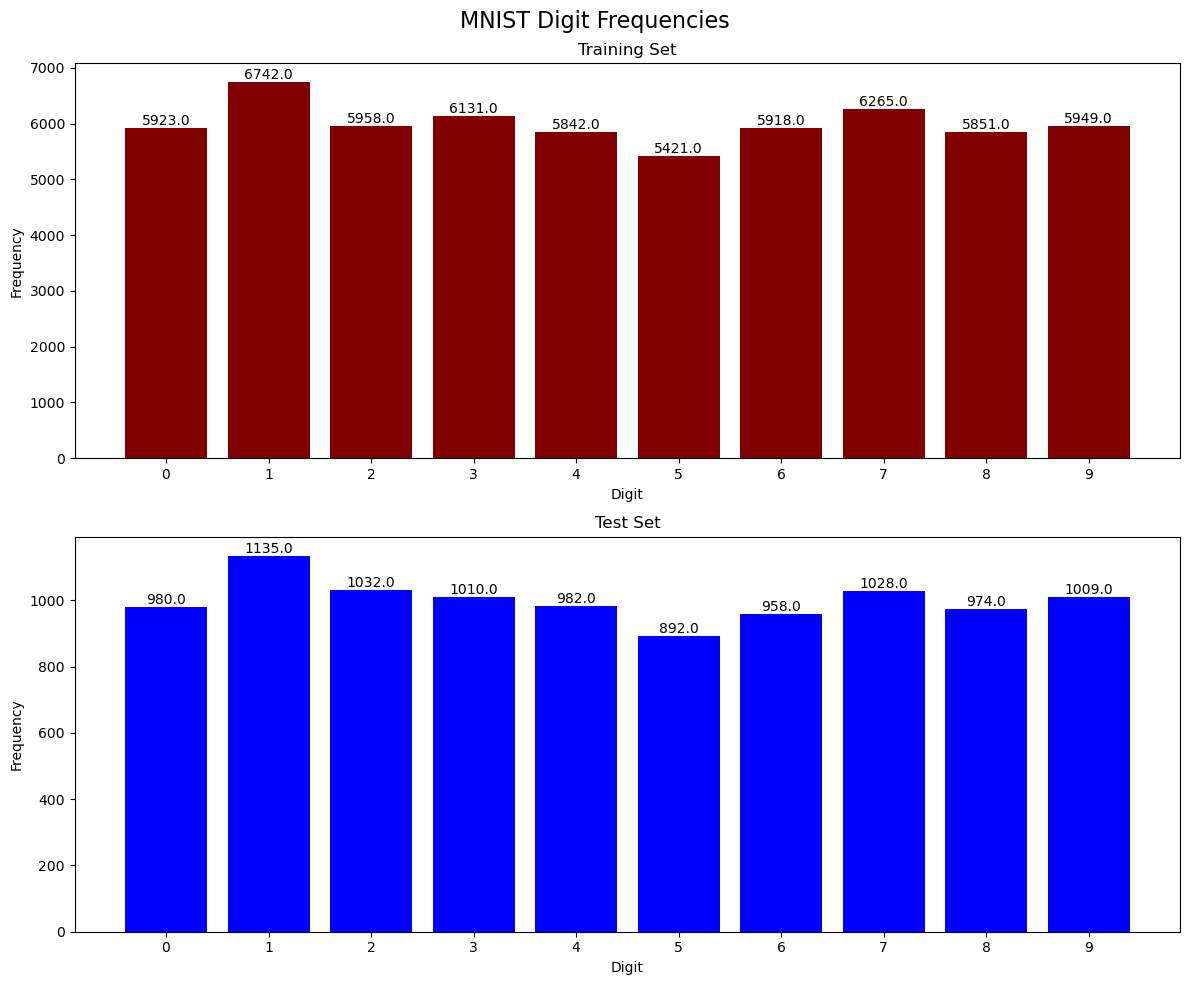

In [7]:
train_freq = np.zeros(n_class_digits)

for img, label in mnist_trainset:
    train_freq[label] += 1

test_freq = np.zeros(n_class_digits)
for img, label in mnist_testset:
    test_freq[label] += 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('MNIST Digit Frequencies', fontsize=16)

# Plot for training set
ax1.bar(range(10), train_freq, color ="maroon")
ax1.set_title('Training Set')
ax1.set_xlabel('Digit')
ax1.set_ylabel('Frequency')
ax1.set_xticks(range(10))
for i, v in enumerate(train_freq):
    ax1.text(i, v, str(v), ha='center', va='bottom')

# Plot for test set
ax2.bar(range(10), test_freq, color="blue")
ax2.set_title('Test Set')
ax2.set_xlabel('Digit')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(10))
for i, v in enumerate(test_freq):
    ax2.text(i, v, str(v), ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Loading MNIST Fashion + EDA

In [ ]:
#hw1 data loader does it for you

# Loading CIFAR10 + EDA

# Loading QuickDraw + EDA

# Train on MNIST Digits

In [8]:
def NN_experiment_digits(X_train, y_train, X_test, y_test, batch_size, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt, final_activation="sigmoid"):
    np.random.seed(0)

    # Initialize a new neural network model
    net = NeuralNetwork(input_size, hidden_sizes, output_size, num_layers, opt)

    # Variables to store performance for each epoch
    train_loss = np.zeros(epochs)
    # train_psnr = np.zeros(epochs)
    # test_psnr = np.zeros(epochs)
    test_acc = np.zeros(epochs)

    n = len(X_train)
    max_t = epochs * np.ceil(n / batch_size) #number of times that update is called

    print("n, epochs, max_t: ", n, epochs, max_t)
    print("opt: ", opt)

    # For each epoch...
    for epoch in range(epochs):
      # Shuffle the dataset
      X_train, y_train = shuffle(X_train, y_train)
      if epoch % 20 == 0:
         print("epoch: ", epoch)
      # Training, here's where you can batch it 
      j = 0
      while j < n:
        X_batch, y_batch = X_train[j:min(j+batch_size, n)], y_train[j:min(j+batch_size, n)]
        # Run the forward pass of the model to get a prediction and record the psnr
        # print("X_batch: ", X_batch.shape, X_batch)
        # print("y_batch: ", y_batch.shape, y_batch)
        net.forward(X_batch)
        # train_psnr[epoch] = psnr(y_batch, prediction)
        # Run the backward pass of the model to compute the loss, record the loss, and update the weights
        train_loss[epoch] = net.backward(y_batch, final_activation = final_activation)
        net.update(max_t = max_t, lr = learning_rate, opt=opt)
        # Testing
        # No need to run the backward pass here, just run the forward pass to compute and record the psnr
        # test_pred = net.forward(X_test)
        # test_psnr[epoch] = psnr(y_test, test_pred)
        j += batch_size
      prediction = net.forward(X_test)
      # print(prediction.shape, y_test.shape)
      test_acc[epoch] = get_acc(np.argmax(prediction, axis=1), np.argmax(y_test, axis=1))
    return net, train_loss, test_acc

In [9]:
print(X_train_digits[0].shape, y_train_digits[0])

X_train_digits_small, y_train_digits_small = X_train_digits[:1000], y_train_digits[:1000]
num_layers = 3 #2 hidden layers
input_size = 784
hidden_size = 32
hidden_sizes = [hidden_size] * (num_layers - 1)
output_size = 10
epochs = 200
batch_size = 256 #sure 
learning_rate = 1e-4
optimizer = "Adam"
final_activation = "sigmoid"

net, train_loss, test_acc = NN_experiment_digits(X_train_digits, y_train_digits, X_test_digits, y_test_digits, batch_size, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt= optimizer, final_activation="sigmoid")

(784,) [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
n, epochs, max_t:  50000 200 39200.0
opt:  Adam
epoch:  0
epoch:  20
epoch:  40
epoch:  60
epoch:  80
epoch:  100
epoch:  120
epoch:  140
epoch:  160
epoch:  180


0.006316568799707498 95.15


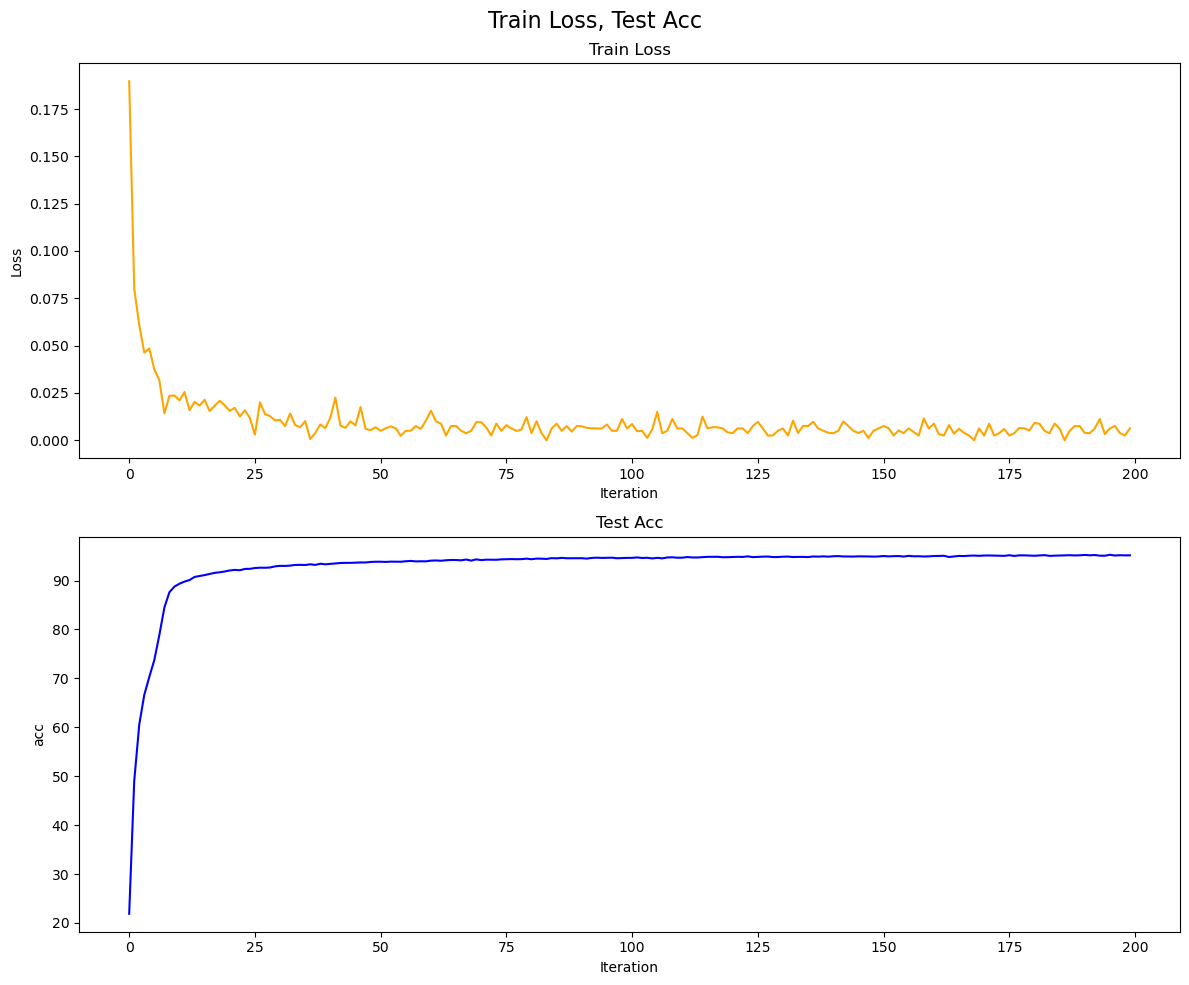

In [10]:
# i = 7
# test, label = X_test_digits[i], y_test_digits[i]
# print(np.argmax(net.forward(test)), label)
print(train_loss[-1], test_acc[-1])
plot_training_curves(train_loss, test_acc)

In [11]:
#time it, v quick 0.000x seconds even argmax
t0 = time.time()
pred = net.forward(X_test_digits[27]) #0.0007 ish
label = np.argmax(net.forward(X_test_digits[27])) #oh it's still like 0.0004 v quick actually
t1 = time.time()
total = t1-t0
total, pred, label

(0.00138092041015625,
 array([3.15153603e-38, 1.00719008e-58, 2.70319147e-26, 6.59276687e-72,
        1.00000000e+00, 1.61129426e-39, 1.98440974e-42, 1.31251610e-18,
        9.67555409e-30, 6.30325450e-24]),
 4)

In [23]:
# Saving
params = net.params
adam_params = net.adam_params
np.savez('model_params.npz', **params)
np.savez('model_adam_params.npz', **params)

# Loading
loaded_data = np.load('model_params.npz')
np.array_equal(loaded_data['W1'], params['W1'])

True